### Function Imports

In [5]:
import numpy as np
%pylab 
rcParams['figure.figsize'] = 12,8
from numba import jit
import random

import copy
import networkx as nx

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Random Matrix Generation Functions

In [6]:
def getRandomConnectivity(N, pct_connected):
    ''' 
    Function that generates an adjacency matrix for an N neuron network.
    
    Inputs: 
        (int) N: Number of neurons in network
        (float) pct_connected: percent chance for two neurons to connect to one another
        
    Outputs: 
        (2dArray(int)) M: Adjacency Matrix
    '''
    M = np.random.rand(N**2).reshape(N,N)
    for i in range(N):
        for j in range(N):
            if (i == j):
                M[i,j] = 0
            else:
                if (M[i,j] < pct_connected):
                    M[i,j] = 1 #i connects to j
                else:
                    M[i,j] = 0
    return M

### Graph theoretic functions to explore role of $k$-cores in network dynamics

In [7]:
def hasKcore(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            
            return False
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return True
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)

            
# TODO get Kcore indices 

def largestKcore(M):
    '''
    Function largestKcore: Returns largest k-value kcore in network M
    
    Inputs:
        (2dArray(int)) M: Adjacency Matrix 
        
    Outputs: 
        (int) k-1: largest k-value kcore in the network
    '''
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    while (hasKcore(M,k)):
        k = k+1
        
    return k - 1
        
    
    
def largestkcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    s=1
    while (s==1):
        
        X = M.copy()
        while(True):
            cur_num_nodes = X.shape[0]
            s = np.sum(X, 0)
            nodes_to_delete = np.where(s < k)[0]
            if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
            
                s=0
                break
            elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
                s=1
                break
            else:
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
        k = k+1
        
    return k - 1

#TODO: Instead of deleting nodes, put 0's on all the connections for the rows and columns that are disconnected
    #Keeps number of all neurons the same so that neuron 3 doesnt become neuron 2 etc. 
    #Look for neurons not in Kcore which are firing and neurons that are in kcore and not firing. 
def kcoreitself(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            # nothing has at least k connections
            return X
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return X
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)



#here we get the largest connected component of  the graph

def largestcomponent(l,N):
    n=np.random.randint(0,N)
    
    boundary=[n]
    b=1
    comp=[n]
    c=1
   
    while(b>0):
        a=boundary.pop()
        
        oldvertex=int(a)
        
        deg=l[oldvertex,0]
        degree=int(deg)
        #print(degree)
        for j in range(degree):
            newvertex=l[oldvertex,j+1]
            q=comp.count(newvertex)
            #print(newvertex)
            q=int(q)
            #print(q)
            if (q==0):
                comp.append(newvertex)
                boundary.append(newvertex)
                #print(newvertex)
                #print(boundary)
            
        b=len(boundary)
            
    #sizeofcomp=len(comp)
    return(comp)

def matrixOfEdges(M,N):
    '''
    Function matrixOfEdges: Returns edgelist from adjacency matrix as 2d numpy array 
    
    Inputs: 
        (2dArray(int)) M: Adjacency Matrix
        (int) N: number of neurons in network, or length of one axis of M
        
    Outputs: 
        (2dArray(int)) E: Edge list of neuronal network. 
    '''
    N = int(N)
    E=np.zeros(N**2).reshape(N,N)  #prepare array with zeros
    k=np.sum(M,0) #array with degree of each vertex
    for i in range(N):
        a=int(k[i]) #degree of the current vertex
        E[i,0]=a  #we put it to the zero row of matrix of edges
    for i in range(N):
        a=int(k[i])
        q=1
        for j in range(N):
            if (M[j,i]==1):
                E[i,q]=j #all the next elements in current column are number of vertices current vertex is connected to
                q=q+1
    return(E)

### Chaos Classifier

In [8]:
def cut(C): 
    return C[int(0.9*len(C)):] #we take the second half of the time, when trajectory is close to SO, H,Q or chaos

def deriv(X):  #just a derivative
    N=len(X)
    if N == 0: 
        return []
    d=zeros(N-1)
    for i in range(N-1):
        d[i]=X[i+1]-X[i]
    return d

def muldev(X): #it is like a derivative but multiplication instead of difference
    N=len(X)
    md = zeros(N-1)
    for i in range(N-1):
        md[i]=X[i+1]*X[i]
    return md

def classifier(C1, timetolerance, Ctolerance):
    '''
    Function classifier: Returns classification of network dynamics. 1 is SO, 0 is chaos, 2 is Fixed point, -1 is error
    
    Inputs: 
        (1dArray(float)) C1: Input array of data
        (float) timetolerance: time scale for oscillation classification
        (float) Ctolerance: variance in input data for oscillation classification
        
    Outputs: 
        (int) checker: Classification of network behavior as defined above. 
    '''
    C=cut(C1) #we look at the second half when it closer to the cycle or whatever it is
    N=len(C)
    countermax=0
    countermin=0
    Cprime=deriv(C)
    Cmd=muldev(Cprime)
    Cpp = deriv(Cprime)
    for i in range(N-2):
        if (Cmd[i]<0): #if sign of derivative changes it means that it max or min
            if (Cpp[i]>0): #if second derivative > 0 it is min
                countermin=countermin+1
            else:
                countermax=countermax+1 # else it is max
    
    max_C = max(C[int(.75*N):N])
    min_C = min(C[int(.75*N):N])
    
    #print(max_C, ",", min_C)
    
    if ((max_C - min_C) < Ctolerance):
        return 2
    
    if ((countermin == 0) and (countermax == 0)):
        return 2
    
    maximums=np.zeros(countermax)
    minimums=np.zeros(countermin)
    maxtimes=np.zeros(countermax)
    mintimes=np.zeros(countermin)
    qmax=0 #counter of max
    qmin=0 #counter of min
    for i in range(N-2):
        if (Cmd[i]<0):
            if (Cpp[i]>0):
                mintimes[qmin]=i #the time when min occurs
                minimums[qmin]=C[i] #the value
                qmin=qmin+1 
            else:
                maxtimes[qmax]=i #the same story for max
                maximums[qmax]=C[i]
                qmax=qmax+1
    
    ### Mihai ~ ADDED TEMPORARY MAGIC NUMBERS TO FIX OFF BY 1 ### 
    min_dim = min(len(maxtimes),len(mintimes))
    maxtimes = maxtimes[:min_dim]
    mintimes = mintimes[:min_dim]
    
    minperiods=deriv(mintimes)
    maxperiods=deriv(maxtimes)
    #print(minperiods)
    #print(maxperiods)

    if(len(maxtimes)+len(mintimes)-2 < 2):  #if the period is too long #Mihai ~ Changed to .any(), but formulation is ambiguous
        print('Increase observation time N*dt')
        return(-1) #-1 is error 
    
    
    checker=1    #we will check conditions for this stuff to be cycle, not chaos. If at lest one of them fails, we put checker to 0
    avper=(sum(minperiods)+sum(maxperiods))*1.0/(countermin+countermax-2) #average period
    #print(avper)
    #print(minimums)
    #print(maximums)
    avmin=sum(minimums)*1.0/countermin #average value of minimum
    avmax=sum(maximums)*1.0/countermax #average value of maximum
    if (avmax-avmin<Ctolerance):
        return(2) #if the difference between min and max smaller than tolerance it is fixed point
    #for i in range(countermin-1):
    for i in range(countermin-2):
        if (abs(minperiods[i]-avper)>timetolerance): #if the deviation from the average larger than the tolerance
            checker=0 #than it is not SO
    #for i in range(countermax-1):
    for i in range(countermax-2):
        if (abs(maxperiods[i]-avper)>timetolerance):
            checker=0
    for i in range(countermin):
        if (abs(minimums[i]-avmin)>Ctolerance):
            checker=0
    for i in range(countermax):
        if (abs(maximums[i]-avmax)>Ctolerance):
            checker=0
    return(checker) #1 is SO, 0 is chaos. 2 is fixed point. -1 is error. 

### Non-chaos Classifier (faster classification but cannot distinguish chaos phase) 

In [9]:
def classify(V, params):
    '''
    Function classify: Returns classification of network dynamics. 1 is stable oscillation, 2 is quiescent fixed point, 3 is high activity fixed point
    
    Inputs: 
        (1dArray(float)) V: Array of voltages or calcium concentrations representing network dynamics for one parameter set
        (1dArray(float)) params: Array of network parameters 
        
    Outputs: 
        (int) classification: Returns classification of network dynamics as defined above. 
    '''
    #Set up some globals 
    
    N = int(params[0])
    n = int(params[1])
    
    #Network uniformly connected but vectorized lets us scale later 
    #for i in range (N/2, N):
    #max_V = max(V[int(N/2):N])
    #min_V = min(V[int(N/2):N])
    max_V = max(V[int(.9*N):N])
    min_V = min(V[int(.9*N):N])
   
            
    V_delta = max_V - min_V
    #print(V_delta)
    
    if V_delta < 0.001: #changed from 1
        if V[N-1] < 15:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        #params[12] = 1
        return 1
        
def classify2(V, params):
    '''
    Function classify2: Returns classification of network dynamics. 1 is stable oscillation across V* boundary, 
                        2 is quiescent fixed point, 3 is high activity fixed point, 4 is stable oscillation where
                        network oscillates above V* boundary, 5 is stable oscillation where network oscillates 
                        below V* boundary.
    
    Inputs: 
        (1dArray(float)) V: Array of voltages or calcium concentrations representing network dynamics for one parameter set
        (1dArray(float)) params: Array of network parameters 
        
    Outputs: 
        (int) classification: Returns classification of network dynamics as defined above. 
    '''
    
    N = int(params[0])
    n = int(params[1])
    
    max_V = max(V[int(N/2):N])
    min_V = min(V[int(N/2):N])
           
    V_delta = max_V - min_V
   
    Vstar = params[5]
    Cstar = params[6]

    if V_delta < 0.1: #changed from 1
        if V[N-1] < Vstar:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        if max_V > params[5] and min_V < params[5]:
            return 1
        if max_V > params[5] and min_V > params[5]:
            return 4
        if max_V < params[5] and min_V < params[5]:
            return 5

### Dynamics Simulation Functions

In [10]:
'''
    All dynamics functions take the same arguments
    
    Inputs: 
        (2d int array) M: Adjacency matrix
        (2d int array) l: Adjacency/edge list
        (1d int array) params: parameter list
        
    Specific outputs vary on a case by cases basis, but in general:
    
    Outputs:
        (2d float array) avV: Average voltage of network at each time step
        (2d float array) avC: Average calcium concentration of network at each time step
        (2d float array) V: Voltage of each neuron at each time step
        (2d float array) C: Calcium concentration of each neuron at each time step 
        
    Any other outputs are not well defined and are used for debugging purposes only
'''

@jit(nopython=True)
def step_mf_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r_1 = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    
    firing_neurons_count = zeros(N*n).reshape(N,n) #Individually count how may neurons are actually firing in this model at a given step N.
    
    avV=zeros(N) #average potential
    avC=zeros(N)  #average calcium
    
    for i in range(n):
        #initial conditions
        #V[0,i]=V0 
        #C[0,i]=C0
        V[0,i]=np.random.uniform(Vstar-3, Vstar+3)
        C[0,i]=np.random.uniform(Cstar-3, Cstar+3)
        if V[0,i] > Vstar: #keep track of and return how many neurons in the network are actually firing  
            firing_neurons_count[0,i] = 1
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    
    for i in range(N - 1): 
        for j in range(n):
            if V[i,j] > Vstar: 
                r = r_1
            else:
                # Set r = r_0 if offset is used
                r = r_0

            if C[i,j] < Cstar: 
                dV = delV 
            else: 
                dV = 0

            V[i+1,j] = (-V[i,j]/tauv + (n-1)*dV*(r + r_0)) * dt + V[i,j]
            if V[i+1,j] > Vstar: 
                firing_neurons_count[i+1,j] = 1
            C[i+1,j] = (-C[i,j]/tauc + (n-1)*delC*(r + r_0)) * dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
            
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n    
    
    return avC, avV, C, V, firing_neurons_count

'''@jit(nopython=True)
def sigmoid_mf_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N)
    
    #avV=zeros(N) #average potencial
    #avC=zeros(N)  #average calcium
    
    for i in range(n):
        #V[0]=V0 #initial conditions
        #C[0]=C0 
        V[0]=np.random.uniform(Vstar-1, Vstar+1)
        C[0]=np.random.uniform(Cstar-1, Cstar+1)
        #avV[0]=n*V0
        #avC[0]=n*C0

    for i in range(N-1):
        V[i+1] = (-V[i]/tauv + (1/(1+exp((C[i]-Cstar)/g_c))) * p * (n-1) * (r/(1+exp((Vstar-V[i])/g_v)) + r_0)) * dt + V[i]
        C[i+1] = (-C[i]/tauc + delC * p * (n-1) * (r/(1+exp((Vstar-V[i])/g_v)) + r_0)) * dt + C[i]
        #avC[i+1]=avC[i+1]+C[i+1]
        #avV[i+1]=avV[i+1]+V[i+1]
            
    #avC /= n
    #avV /= n
            
    return(C, V)'''

@jit(nopython=True)
def sigmoid_mf_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    sump=zeros(n)
    avV=zeros(N) #average potential
    avC=zeros(N)  #average calcium
    P=zeros(n)
    
    for i in range(n):
        #initial conditions
        #V[0,i]=V0 
        #C[0,i]=C0
        V[0,i]=np.random.uniform(Vstar-5, Vstar+5)
        C[0,i]=np.random.uniform(Cstar-5, Cstar+5)
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
        
    for i in range(N-1):
        for j in range(n):
            sump[j]=0
        for j in range(n):
            P[j] = (r - r_0)/(1+exp((Vstar-V[i,j])/g_v)) + r_0
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + delV*sump[j]*(1/(1+exp((C[i,j]-Cstar)/g_c))) )*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
    return(avC,avV,C,V)

@jit(nopython=True)
def step_hetero_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r_1 = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    #P=zeros(n)  # function P(V), sigmoid
    P = zeros(N*n).reshape(N,n)
    deltaV=zeros(n)
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    firing_neurons_count = zeros(N*n).reshape(N,n) #Individually count how may neurons are actually firing in this model at a given step N.
    
    for i in range(n):
        V[0,i]= np.random.uniform(Vstar - 3, Vstar + 3)#V0 #initial conditions
        C[0,i]= np.random.uniform(Cstar - 3, Cstar + 3)#C0 
        if V[0,i] > Vstar: #keep track of and return how many neurons in the network are actually firing  
            firing_neurons_count[0,i] = 1
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            if (V[i,j]>Vstar): #V[i,j] stores voltage of each neuron instead of returning the average voltage 
                P[i,j]=r_1+r_0
            else:
                P[i,j]=r_0
                
            if (C[i,j]<Cstar):
                deltaV[j]=delV #change from 1.2 
            else:
                deltaV[j]=0#delVmin #changed from .4
        for j in range(n):
            a=int(l[j,0]) #a should give number of firing neighbors 
            for k in range(a):
                b = int(l[j,k+1])
                sump[j]=sump[j]+P[i,b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + deltaV[j]*sump[j])*dt + V[i,j]
            if V[i+1,j] > Vstar: 
                firing_neurons_count[i+1,j] = 1 #used to return count of firing neurons later
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
    return(avC,avV, C, V)

@jit(nopython=True)
def sigmoid_hetero_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    #res = int(params[12]) #resulting classification 
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        #V[0,i] = np.random.uniform(Vstar-1, Vstar+1)
        #C[0,i] = np.random.uniform(Cstar-1, Cstar+1)
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            sump[j]=0
        for j in range(n):
            P[j] = (r - r_0)/(1+exp((Vstar-V[i,j])/g_v)) + r_0
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + delV*sump[j]*(1/(1+exp((C[i,j]-Cstar)/g_c))) )*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        #for j in range(n):
        #    sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
   
    #return(avC,avV,C,V)
    return(avC,avV,C,V,sump)

### Network Definition

In [38]:
'''
    Each neuronal network defined by M and l are saved as their own object, along with 
    its specific parameters in the params array. Not all features of params are used for
    each network. For instance, the params array for a step function contains g_v and g_c
    parameters though in reality it is a step function
'''
class Network: 
    def __init__(self, M, l, params):
        '''
            Constructor for network object. MUST include M, l, and params to function. 
        '''
        self.M_init = M
        self.l_init = l 
        self.M = M
        self.l = l
        self.params = params
        self.N = int(params[0])
        self.n_init = int(params[1])
        self.n = int(params[1])
        self.dt = params[2]
        self.tauv = params[3]
        self.tauc = params[4]
        self.Vstar = params[5]
        self.Cstar = params[6]
        self.delV = params[7]
        self.delC = params[8]
        self.r = params[9]
        self.V0 = params[10]
        self.C0 = params[11]
        self.g_v = params[12]
        self.g_c = params[13]
        self.r_0 = params[14]
        self.n_edges = np.sum(self.l[:,0])
        self.kill_order = []
        
    def kill_neuron(self):
        '''
            Kills a single neuron at index 1 and changes M, l, and params accordingly for network
        '''
        x = 1
        self.n -= 1
        self.params[1] = self.n
        self.M = np.delete(self.M,x,axis=0)
        self.M = np.delete(self.M,x,axis=1)
        #self.M[x] = np.zeros(self.n_init)
        #self.M[:,x] = np.zeros(self.n_init)
        self.l = matrixOfEdges(self.M, self.n)
        
    def kill_neuron2(self, n):
        '''
            Kills n neurons from the network always from index -1 and changes M, l, and params accordingly.
        '''
        x = -1 #0
        for i in range(int(n)):
            self.M = np.delete(self.M, x, axis=0)
            self.M = np.delete(self.M, x, axis=1)
        self.n -= n
        self.params[1] = self.n
        self.l = matrixOfEdges(self.M, self.n)

    def killEdge(self):
        '''
            Kills a single edge from the network at random 
        '''
        l_copy = copy.deepcopy(self.l)
        
        non_zero_rows = []
        
        for i in range(self.n):
            if l_copy[i,0] != 0:
                non_zero_rows.append(i)
            # Experimental removal of neurons as all incoming edges are killed 
            #else:
            #    self.n -= 1
            
        
        #randomly pick a row that has some connections
        if len(non_zero_rows) == 0:
            return False
        
        row_idx = random.randint(0,len(non_zero_rows) - 1)
        row = non_zero_rows[row_idx]
        
        if l_copy[row,0] == 0:
            self.l = l_copy
            return False
        
        else: 
            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]
            
            #remove entry and roll array 
            row_reinsert[edge_idx] = 0
            
            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert
            
            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            return True
        
    def killEdge2(self, n):
        '''
            Kills n edges from the network at random if first iteration, or in order determined by kill_order
        '''
        for i in range(n): 
            l_copy = copy.deepcopy(self.l)
        
            non_zero_rows = []

            for j in range(self.n):
                if l_copy[j,0] != 0:
                    non_zero_rows.append(j)
                    
            row = non_zero_rows[self.kill_order[i][0]]
            
        
            #randomly pick edge
            edge_idx = self.kill_order[i][1]
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
        
    def init_kill_order(self):
        '''
            Initializes the order in which edges are to be killed for all phase diagram runs. 
        '''
        while True:
            l_copy = copy.deepcopy(self.l)

            non_zero_rows = []

            for i in range(self.n):
                if l_copy[i,0] != 0:
                    non_zero_rows.append(i)
                # Experimental removal of neurons as all incoming edges are killed 
                #else:
                #    self.n -= 1


            #randomly pick a row that has some connections
            if len(non_zero_rows) == 0:
                #reset initial values 
                self.M = self.M_init
                self.l = self.l_init
                self.n_edges = np.sum(self.l_init[:,0])
                break

            row_idx = random.randint(0,len(non_zero_rows) - 1)
            row = non_zero_rows[row_idx]

            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            self.kill_order.append((row_idx, edge_idx))
     
    # TODO: FINISH
    def simdyn(self, M, l, params, connectivity="heterogeneous", activation="sigmoid"):
        '''
        Function simdyn: Simulates dynamics of network for given parameter set and adjacency matrix
        
        Inputs:
            M: Network adjacency matrix
            l: Network edge-list as matrix
            params: List of parameters (see constructor function for specifics)
            connectivity: Definition of whether network is heterogeneously connected or homogeneously 
                connected. Either input 'heterogeneous' or 'mean field'.
            activation: Definition of activation function of neurons in network. Either 'sigmoid' or 'step'.
            
        Outputs: 
            Data regarding network dynamics, C and V at different neurons at different time steps. 
            See called dynamics functions for specific information about outputs. Prints message if 
            error in inputs. 
        '''
        if connectivity ==  "mean field" and activation == "step":
            return step_mf_dyn(self.M, self.l, self.params)
        elif connectivity ==  "mean field" and activation == "sigmoid":
            return sigmoid_mf_dyn(self.M, self.l, self.params)
        elif connectivity == "heterogeneous" and activation == "step":
            return step_hetero_dyn(self.M, self.l, self.params)
        elif connectivity == "heterogeneous" and activation == "sigmoid":
            return sigmoid_hetero_dyn(self.M, self.l, self.params)
        else:
            print("!!! Check network type and activation function !!!")
            
    def phase_diagram(self, x_param="delV", y_param="n", x_min=0.1, x_max=25., x_step=0.1, 
                      y_min=2, y_max=100, y_step=1, tracing="full",
                      connectivity="heterogeneous", activation="sigmoid"):
        '''
        Inputs:
            x_param (str): x parameter for phase space, either "delV", "delV", "g_v", or "g_c"
            y_param (str): y parameter for phase space, "n"
            tracing (str): Type of tracing for phase boundary. 
                        "full": complete phase space is plotted 
                        "boundary": only select boundaries get traced
        Outputs: 
            Data that can be used to plot phase diagram of network dynamics for select parameters 
        '''
        #dictionary mapping inputs to index in params array
        param_idx = {}
        param_idx["n"]    = 1
        param_idx["delV"] = 7
        param_idx["delC"] = 8
        param_idx["g_v"]  = 12
        param_idx["g_c"]  = 13
        
        #indices of chosen parameters in params array. idx1 refers to x axis parameter, idx2 to y axis
        param_idx1 = param_idx[x_param]
        param_idx2 = param_idx[y_param]
        
        x_space = np.arange(x_min, x_max, x_step)
        y_space = np.arange(y_min, y_max, y_step)
        
        #import pdb; pdb.set_trace()
        
        if tracing == "full":
            return self.full_space_phase(param_idx1, param_idx2, x_space, y_space, connectivity, activation)
        elif tracing == "boundary":
            return self.boundary_trace_phase(param_idx1, param_idx2, x_space, y_space, connectivity, activation)
        
    def full_space_phase(self, param_idx1, param_idx2, x_space, y_space, connectivity, activation):
        x_len = len(x_space)
        y_len = len(y_space)
        phase = np.zeros((y_len, x_len))
        
        for i in reversed(range(y_len)):
            self.M = self.M_init
            self.l = self.l_init
            
            #assumed that y index will refer to neurons
            self.params[param_idx2] = self.n_init
            self.n = self.n_init
            
            if (self.n - y_space[i]) > 0:
                self.kill_neuron2(self.n - y_space[i])
                
            for j in range(x_len):
                #import pdb; pdb.set_trace()
                self.params[param_idx1] = x_space[j]
                C,V,c_arr,v_arr,sump = self.simdyn(self.M, self.l, self.params, connectivity, activation)
                check = classify2(V, self.params)
                phase[i,j] = check
                
            print("Visited n = {}".format(i))
            
        print("loop complete")
        
        return phase
    
    def boundary_trace_phase(self, param_idx1, param_idx2, x_space, y_space, connectivity, activation):
        x_len = len(x_space)
        y_len = len(y_space)
        phase = {}
        
        for i in range(x_len):
            self.M = self.M_init
            self.l = self.l_init
            self.params[param_idx2] = self.n_init
            self.params[param_idx1] = x_space[i]
            
            C,V,c_arr,v_arr,sump = self.simdyn(self.M, self.l, self.params, connectivity, activation)
            check = classify(V, self.params)
            
            for j in reversed(range(y_len)):
                self.kill_neuron2(self.n - y_space[j])
                C,V,c_arr,v_arr,sump = self.simdyn(self.M, self.l, self.params, connectivity, activation)
                check2 = classify(V, self.params)
                
                if check2 != check: 
                    if "{}_{}".format(check,check2) not in phase:
                        phase["{}_{}".format(check,check2)] = [[network.params[param_idx2]],
                                                               [network.params[param_idx2]]]
                    else:
                        phase["{}_{}".format(check,check2)][0].append(network.params[param_idx2])
                        phase["{}_{}".format(check,check2)][1].append(network.params[param_idx1])
                    break
                    
            print("Visited n = {}, delV = {}".format(params[param_idx2], params[param_idx1]))
            
        print("loop complete")
        
        return phase

In [12]:
# Incomplete functions that would be nice to have in the class. 
def reset(self, delV=self.params[7], delC=self.params[8]):
    '''
    Function reset: resets network and parameters to original size

    Optional Inputs:
        delV: New delV value to be set for network
        delC: New delC value to be set for network

    '''
    self.delV = delV
    self.params[7] = delV
    self.delC = delC
    self.params[8] = delC

    self.M = self.M_init
    self.l = self.l_init
    self.n = len(self.M_init)
    self.params[1] = self.n

NameError: name 'self' is not defined

### Simulation of network dynamics for select parameters

In [465]:
# Setup simulation parameters 
n = 100
p = 1
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [11]:
#mean field step function limit
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 8. #1.
delVmin = delV/3 #delV/3
delC= 0.035 #0.01
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)


C,V,f = network.simdyn(network.M, network.l, network.params, connectivity="mean field", activation="step")

In [469]:
# Setup simulation parameters 
n = 100
p = 1
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [476]:
#Heterogeneous sigmoid 
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 7. #1.
delVmin = delV/3 #delV/3
delC= 0.025 #0.01
r_1= 70#*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5#*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)

avC,avV,C,V,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous", activation="sigmoid")

In [37]:
V[-1]

array([ 2.4715868 , 30.29399066, 35.68310282, 38.65606584,  2.92852859,
       39.93949627, 31.81629863, 15.21494473,  6.93634071, 12.29306525,
        9.92702531, 13.38448508,  2.25647126, 23.36626678,  2.47562946])

2


Text(0, 0.5, 'V')

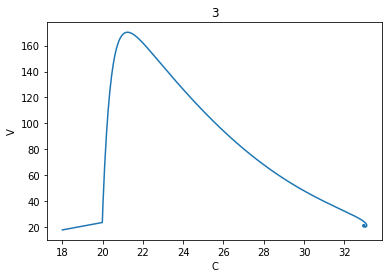

In [477]:
print(classifier(avV, 1/dt, 0.1)) #0 is chaos, 1 is SO, 2 is FP, -1 is error
plot(avC[:],avV[:])
title(classify(avV,params))
xlabel("C")
ylabel("V")

# Phase Diagrams

Phase Diagrams for network dynamics exist in two flavors: 
1. Boundary Tracing
    - Optimal for getting a rough sketch of phase boundary. 
    - Sensitive to unexpected behavior of heterogeneously connected network.
2. Color mapping 
    - Optimal for completely mapping out phase space of possible dynamics.
    - Slower. Not all of the phase space is interesting. 

### Phase Dagram Functions test

In [45]:
n = 100
p = 3/4 #1/6
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [ ]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1. #1.
delVmin = delV/3 #delV/3
delC= 0.035 #0.115
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5 #3
g_c = 5 #3

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

delVmin = 0.1
delVmax = 25.
dV = 0.1
nmin = 2
nmax = 101
dn = 1

network = Network(M, l, params)

phase = network.phase_diagram("delV", "n", delVmin, delVmax, dV, nmin, nmax, dn, 
                              "boundary", "heterogeneous", "sigmoid")

Visited n = 2.0, delV = 0.1
Visited n = 2.0, delV = 0.2
Visited n = 2.0, delV = 0.30000000000000004
Visited n = 2.0, delV = 0.4
Visited n = 2.0, delV = 0.5
Visited n = 2.0, delV = 0.6
Visited n = 2.0, delV = 0.7000000000000001
Visited n = 2.0, delV = 0.8
Visited n = 2.0, delV = 0.9
Visited n = 2.0, delV = 1.0
Visited n = 2.0, delV = 1.1
Visited n = 2.0, delV = 1.2000000000000002
Visited n = 2.0, delV = 1.3000000000000003
Visited n = 71.0, delV = 1.4000000000000001
Visited n = 81.0, delV = 1.5000000000000002
Visited n = 87.0, delV = 1.6
Visited n = 91.0, delV = 1.7000000000000002
Visited n = 95.0, delV = 1.8000000000000003
Visited n = 98.0, delV = 1.9000000000000001
Visited n = 33.0, delV = 2.0
Visited n = 31.0, delV = 2.1
Visited n = 30.0, delV = 2.2
Visited n = 28.0, delV = 2.3000000000000003
Visited n = 27.0, delV = 2.4000000000000004
Visited n = 26.0, delV = 2.5000000000000004
Visited n = 25.0, delV = 2.6
Visited n = 24.0, delV = 2.7
Visited n = 23.0, delV = 2.8000000000000003
Visit

Text(0, 0.5, 'Number of Neurons, $n$')

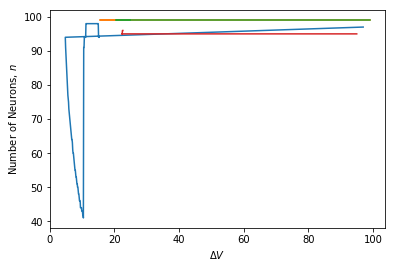

In [44]:
for i in phase:
    plt.plot(phase[i][1], phase[i][0])
xlabel(r"$\Delta V$")
ylabel("Number of Neurons, $n$")

Text(0, 0.5, 'Neuron Count, $N$')

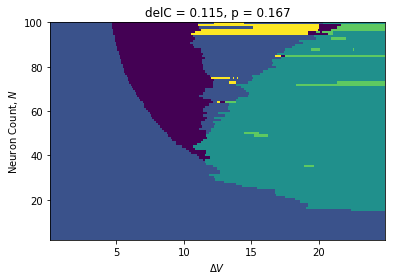

In [31]:
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
#imshow(img, aspect='auto', extent=[V_space[0],V_space[-1],n_space[0],n_space[-1]])
imshow(img, aspect='auto', extent=[0.1,24.9,2,100])
plt.title("delC = {:.3f}, p = {:.3f}".format(delC, p))
#plt.hlines(np.array(kcore_transition), 1, 24, linestyles='solid', linewidths=0.75, colors='k')
xlabel(r"$\Delta V$")
ylabel(r"Neuron Count, $N$")

### Heterogeneous connectivity, Sigmoid activation, Color Mapping

In [8]:
n = 100
p = 1/6
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [38]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1. #1.
delVmin = delV/3 #delV/3
delC= 0.115 #0.035
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 3 #5
g_c = 3 #5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dV = 0.1
delVmax = 25.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,n+1)

phase = np.zeros((len(n_space), len(V_space)))

network = Network(M, l, params)

for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(V_space)):
        #import pdb; pdb.set_trace()
        network.params[7] = V_space[j]
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous",
                                             activation="sigmoid")
        check = classify2(V,params)
        phase[i,j] = check
    print("Visited n = {}".format(i))

print('loop complete')


Visited n = 98
Visited n = 97
Visited n = 96
Visited n = 95
Visited n = 94
Visited n = 93
Visited n = 92
Visited n = 91
Visited n = 90
Visited n = 89
Visited n = 88
Visited n = 87
Visited n = 86
Visited n = 85
Visited n = 84
Visited n = 83
Visited n = 82
Visited n = 81
Visited n = 80
Visited n = 79
Visited n = 78
Visited n = 77
Visited n = 76
Visited n = 75
Visited n = 74
Visited n = 73
Visited n = 72
Visited n = 71
Visited n = 70
Visited n = 69
Visited n = 68
Visited n = 67
Visited n = 66
Visited n = 65
Visited n = 64
Visited n = 63
Visited n = 62
Visited n = 61
Visited n = 60
Visited n = 59
Visited n = 58
Visited n = 57
Visited n = 56
Visited n = 55
Visited n = 54
Visited n = 53
Visited n = 52
Visited n = 51
Visited n = 50
Visited n = 49
Visited n = 48
Visited n = 47
Visited n = 46
Visited n = 45
Visited n = 44
Visited n = 43
Visited n = 42
Visited n = 41
Visited n = 40
Visited n = 39
Visited n = 38
Visited n = 37
Visited n = 36
Visited n = 35
Visited n = 34
Visited n = 33
Visited n 

In [36]:
kcore_transition

[99, 92, 83, 75, 63, 52, 48, 41, 36, 19, 4, 2]

Text(0, 0.5, 'Neuron Count, $N$')

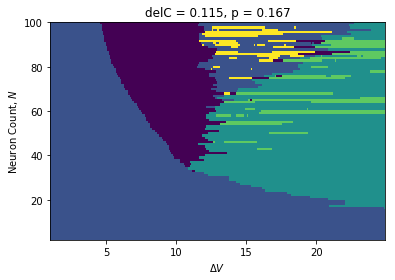

In [39]:
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
#imshow(img, aspect='auto', extent=[V_space[0],V_space[-1],n_space[0],n_space[-1]])
imshow(img, aspect='auto', extent=[V_space[0],V_space[-1],n_space[0],n_space[-1]])
plt.title("delC = {:.3f}, p = {:.3f}".format(delC, p))
#plt.hlines(np.array(kcore_transition), 1, 24, linestyles='solid', linewidths=0.75, colors='k')
xlabel(r"$\Delta V$")
ylabel(r"Neuron Count, $N$")
#plt.savefig("paper_figures/full_space_p_0167.png",dpi=400)


In [12]:
data

array([[2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

### Heterogeneous connectivity, Sigmoid activation, Boundary Trace

In [1052]:
n = 100
p = 3/4
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [1089]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1. #1.
delVmin = delV/3 #delV/3
delC= 0.035 #0.03
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dV = 0.1
delVmax = 25.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,n+1)

phase = {}

network = Network(M, l, params)

for i in range(len(V_space)):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.params[7] = V_space[i]
    network.n = n
    
    C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous", 
                                          activation="sigmoid")
    check = classify(V,network.params)
    
    for j in reversed(range(len(n_space))):
        network.kill_neuron2(network.n - n_space[j])
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous", 
                                              activation="sigmoid")
        check2 = classify(V,network.params)
        if check2 != check:
            if "{}_{}".format(check,check2) not in phase:
                phase["{}_{}".format(check,check2)] = [[network.params[1]],[network.params[7]]]
            else:
                phase["{}_{}".format(check,check2)][0].append(network.params[1])
                phase["{}_{}".format(check,check2)][1].append(network.params[7])
            break
    print("Visited n = {}, delV = {}".format(params[1], params[7]))
        
'''
for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(V_space)):
        #import pdb; pdb.set_trace()
        network.params[7] = V_space[j]
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous",
                                             activation="sigmoid")
        check = classify2(V,network.params)
        phase[i,j] = check
    print("Visited n = {}".format(i))
'''

print('loop complete')

Visited n = 2.0, delV = 1.0
Visited n = 2.0, delV = 1.1
Visited n = 2.0, delV = 1.2000000000000002
Visited n = 2.0, delV = 1.3000000000000003
Visited n = 73.0, delV = 1.4000000000000004
Visited n = 82.0, delV = 1.5000000000000004
Visited n = 88.0, delV = 1.6000000000000005
Visited n = 92.0, delV = 1.7000000000000006
Visited n = 96.0, delV = 1.8000000000000007
Visited n = 99.0, delV = 1.9000000000000008
Visited n = 33.0, delV = 2.000000000000001
Visited n = 32.0, delV = 2.100000000000001
Visited n = 30.0, delV = 2.200000000000001
Visited n = 29.0, delV = 2.300000000000001
Visited n = 27.0, delV = 2.4000000000000012
Visited n = 26.0, delV = 2.5000000000000013
Visited n = 25.0, delV = 2.6000000000000014
Visited n = 24.0, delV = 2.7000000000000015
Visited n = 23.0, delV = 2.8000000000000016
Visited n = 23.0, delV = 2.9000000000000017
Visited n = 22.0, delV = 3.0000000000000018
Visited n = 21.0, delV = 3.100000000000002
Visited n = 24.0, delV = 3.200000000000002
Visited n = 27.0, delV = 3.3

Visited n = 77.0, delV = 19.900000000000016
Visited n = 77.0, delV = 20.000000000000018
Visited n = 77.0, delV = 20.100000000000016
Visited n = 77.0, delV = 20.200000000000017
Visited n = 77.0, delV = 20.30000000000002
Visited n = 79.0, delV = 20.400000000000016
Visited n = 79.0, delV = 20.500000000000018
Visited n = 79.0, delV = 20.600000000000016
Visited n = 79.0, delV = 20.700000000000017
Visited n = 79.0, delV = 20.80000000000002
Visited n = 79.0, delV = 20.900000000000016
Visited n = 79.0, delV = 21.000000000000018
Visited n = 79.0, delV = 21.10000000000002
Visited n = 79.0, delV = 21.200000000000017
Visited n = 79.0, delV = 21.30000000000002
Visited n = 79.0, delV = 21.40000000000002
Visited n = 79.0, delV = 21.500000000000018
Visited n = 79.0, delV = 21.60000000000002
Visited n = 79.0, delV = 21.700000000000017
Visited n = 79.0, delV = 21.80000000000002
Visited n = 79.0, delV = 21.90000000000002
Visited n = 79.0, delV = 22.000000000000018
Visited n = 79.0, delV = 22.100000000000

In [1090]:
network.M = M
network.l = l
network.n = n
k = largestkcore(network.M)
kcore_transition = []
for i in range(n-1):
    network.kill_neuron2(1)
    new_k = largestkcore(network.M)
    if new_k != k:
        kcore_transition.append(network.n + 1)
        k = new_k


In [1047]:
for key, value in phase.items() :
    print (key)

1_2
3_1
3_2


In [1022]:
kcore_transition

[99,
 98,
 97,
 94,
 93,
 92,
 91,
 89,
 87,
 86,
 85,
 84,
 83,
 81,
 79,
 78,
 76,
 75,
 74,
 72,
 70,
 69,
 68,
 66,
 65,
 64,
 61,
 60,
 59,
 57,
 55,
 54,
 53,
 52,
 50,
 49,
 47,
 45,
 43,
 42,
 40,
 38,
 37,
 36,
 34,
 32,
 31,
 30,
 28,
 26,
 23,
 21,
 20,
 19,
 17,
 16,
 14,
 12,
 11,
 10,
 8,
 6,
 3,
 2,
 1]

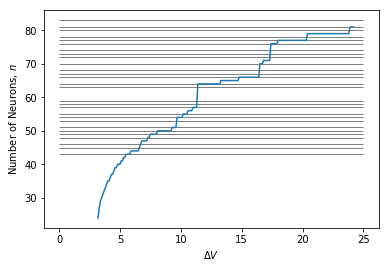

In [1093]:
#for i in phase:
#    plt.plot(phase[i][1], phase[i][0])
    
plt.hlines(np.array(kcore_transition[12:40]), 0, 25, linestyles='solid', linewidths=0.5)
plt.plot(phase['1_3'][1], phase['1_3'][0])
#plt.plot(phase['1_2'][1], phase['1_2'][0])
#plt.plot(phase['5_1'][1], phase['5_1'][0])
#plt.plot(phase['2_5'][1], phase['2_5'][0])
#plt.plot(phase['1_4'][1], phase['1_4'][0])
xlabel(r"$\Delta V$")
ylabel("Number of Neurons, $n$")
#plt.show()
plt.savefig("paper_figures/phase_with_k2.png", dpi=400)

### Mean field limit, step function, full space

In [92]:
n = 100
p = 1
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [93]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1. #1.
delVmin = delV/3 #delV/3
delC= 0.03 #0.03
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 0#5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dV = 0.1
delVmax = 25.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,n+1)

phase = np.zeros((len(n_space), len(V_space)))

network = Network(M, l, params)

for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(V_space)):
        #import pdb; pdb.set_trace()
        network.params[7] = V_space[j]
        C,V,f = network.simdyn(network.M, network.l, network.params, connectivity="mean field",
                                             activation="step")
        check = classify(V,params)
        phase[i,j] = check
    print("Visited n = {}".format(i))

print('loop complete')

Visited n = 98
Visited n = 97
Visited n = 96
Visited n = 95
Visited n = 94
Visited n = 93
Visited n = 92
Visited n = 91
Visited n = 90
Visited n = 89
Visited n = 88
Visited n = 87
Visited n = 86
Visited n = 85
Visited n = 84
Visited n = 83
Visited n = 82
Visited n = 81
Visited n = 80
Visited n = 79
Visited n = 78
Visited n = 77
Visited n = 76
Visited n = 75
Visited n = 74
Visited n = 73
Visited n = 72
Visited n = 71
Visited n = 70
Visited n = 69
Visited n = 68
Visited n = 67
Visited n = 66
Visited n = 65
Visited n = 64
Visited n = 63
Visited n = 62
Visited n = 61
Visited n = 60
Visited n = 59
Visited n = 58
Visited n = 57
Visited n = 56
Visited n = 55
Visited n = 54
Visited n = 53
Visited n = 52
Visited n = 51
Visited n = 50
Visited n = 49
Visited n = 48
Visited n = 47
Visited n = 46
Visited n = 45
Visited n = 44
Visited n = 43
Visited n = 42
Visited n = 41
Visited n = 40
Visited n = 39
Visited n = 38
Visited n = 37
Visited n = 36
Visited n = 35
Visited n = 34
Visited n = 33
Visited n 

Text(0.5, 1.0, 'delC = 0.030, p = 1.000, r_0 = 0.000')

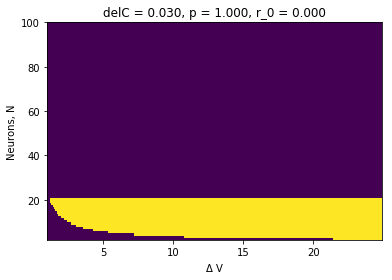

In [94]:
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
imshow(img, aspect='auto', extent=[V_space[0],V_space[-1],n_space[0],n_space[-1]])
ylabel("Neurons, N")
xlabel(r"$\Delta$ V")
plt.title("delC = {:.3f}, p = {:.3f}, r_0 = {:.3f}".format(delC, p, r_0))

In [95]:
data

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.]])

### Mean field limit, step function, boundary trace

In [359]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1. #1.
delVmin = delV/3 #delV/3
delC= 0.01 #0.03
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 0#5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dV = 0.1
delVmax = 25.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,n+1)

phase = {}

network = Network(M, l, params)

for i in range(len(V_space)):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.params[7] = V_space[i]
    network.n = n
    
    C,V,f = network.simdyn(network.M, network.l, network.params, connectivity="mean field", 
                                          activation="step")
    check = classify(V,network.params)
    
    for j in reversed(range(len(n_space))):
        network.kill_neuron2(network.n - n_space[j])
        C,V,f = network.simdyn(network.M, network.l, network.params, connectivity="mean field", 
                                              activation="step")
        check2 = classify(V,network.params)
        if check2 != check:
            if "{}_{}".format(check,check2) not in phase:
                phase["{}_{}".format(check,check2)] = [[network.params[1]],[network.params[7]]]
            else:
                phase["{}_{}".format(check,check2)][0].append(network.params[1])
                phase["{}_{}".format(check,check2)][1].append(network.params[7])
            break
    print("Visited n = {}, delV = {}".format(params[1], params[7]))
        
'''
for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(V_space)):
        #import pdb; pdb.set_trace()
        network.params[7] = V_space[j]
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous",
                                             activation="sigmoid")
        check = classify2(V,network.params)
        phase[i,j] = check
    print("Visited n = {}".format(i))
'''

print('loop complete')

Visited n = 58.0, delV = 1.0
Visited n = 58.0, delV = 1.1
Visited n = 58.0, delV = 1.2000000000000002
Visited n = 58.0, delV = 1.3000000000000003
Visited n = 58.0, delV = 1.4000000000000004
Visited n = 58.0, delV = 1.5000000000000004
Visited n = 58.0, delV = 1.6000000000000005
Visited n = 58.0, delV = 1.7000000000000006
Visited n = 58.0, delV = 1.8000000000000007
Visited n = 58.0, delV = 1.9000000000000008
Visited n = 58.0, delV = 2.000000000000001
Visited n = 58.0, delV = 2.100000000000001
Visited n = 58.0, delV = 2.200000000000001
Visited n = 58.0, delV = 2.300000000000001
Visited n = 58.0, delV = 2.4000000000000012
Visited n = 58.0, delV = 2.5000000000000013
Visited n = 58.0, delV = 2.6000000000000014
Visited n = 58.0, delV = 2.7000000000000015
Visited n = 58.0, delV = 2.8000000000000016
Visited n = 58.0, delV = 2.9000000000000017
Visited n = 58.0, delV = 3.0000000000000018
Visited n = 58.0, delV = 3.100000000000002
Visited n = 58.0, delV = 3.200000000000002
Visited n = 58.0, delV =

KeyboardInterrupt: 

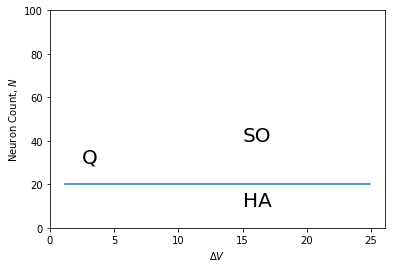

In [357]:
plt.ylim(0,100)
plt.xlabel(r'$\Delta V$')
plt.ylabel(r'Neuron Count, $N$')
plt.text(15, 40, 'SO', fontsize=20)
plt.text(15, 10, 'HA', fontsize=20)
plt.text(2.5, 30, 'Q', fontsize=20)
for i in phase:
    plt.plot(phase[i][1], phase[i][0])
    
#plt.savefig('paper_figures/step_mf.png', dpi=300)

In [358]:
for key, value in phase.items() :
    print (key)

2_3


### Mean Field limit Sigmoid Activation

In [525]:
n = 100
p = 1
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [527]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1. #1.
delVmin = delV/3 #delV/3
delC= 0.03 #0.03
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dV = 0.1
delVmax = 25.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,n+1)

phase = np.zeros((len(n_space), len(V_space)))

network = Network(M, l, params)

for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(V_space)):
        #import pdb; pdb.set_trace()
        network.params[7] = V_space[j]
        avC,avV,C,V = network.simdyn(network.M, network.l, network.params, connectivity="mean field",
                                             activation="sigmoid")
        check = classify2(avV,params)
        phase[i,j] = check
    print("Visited n = {}".format(i))

print('loop complete')

Visited n = 98
Visited n = 97
Visited n = 96
Visited n = 95
Visited n = 94
Visited n = 93
Visited n = 92
Visited n = 91
Visited n = 90
Visited n = 89
Visited n = 88
Visited n = 87
Visited n = 86
Visited n = 85
Visited n = 84
Visited n = 83
Visited n = 82
Visited n = 81
Visited n = 80
Visited n = 79
Visited n = 78
Visited n = 77
Visited n = 76
Visited n = 75
Visited n = 74
Visited n = 73


KeyboardInterrupt: 

# Network Connectivity plots for small samples

### Heterogeneously connected, sigmoid activation 

In [270]:
# Setup simulation parameters 
n = 40
p = 1/4 #1/6
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [271]:
#Phase diagram 
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 0.1 #1.
delVmin = delV/3 #delV/3
delC= 0.035 #0.01
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)
#network.kill_neuron2(20)

dV = 0.1
delVmax = 8.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,network.n+1)

phase = np.zeros((len(n_space), len(V_space)))



for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(V_space)):
        #import pdb; pdb.set_trace()
        network.params[7] = V_space[j]
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous",
                                             activation="sigmoid")
        check = classify2(V,params)
        phase[i,j] = check
    print("Visited n = {}".format(i))

print('loop complete')

Visited n = 38
Visited n = 37
Visited n = 36
Visited n = 35
Visited n = 34
Visited n = 33
Visited n = 32
Visited n = 31
Visited n = 30
Visited n = 29
Visited n = 28
Visited n = 27
Visited n = 26
Visited n = 25
Visited n = 24
Visited n = 23
Visited n = 22
Visited n = 21
Visited n = 20
Visited n = 19
Visited n = 18
Visited n = 17
Visited n = 16
Visited n = 15
Visited n = 14
Visited n = 13
Visited n = 12
Visited n = 11
Visited n = 10
Visited n = 9
Visited n = 8
Visited n = 7
Visited n = 6
Visited n = 5
Visited n = 4
Visited n = 3
Visited n = 2
Visited n = 1
Visited n = 0
loop complete


Text(0.5, 1.0, 'delC = 0.035, p = 0.250')

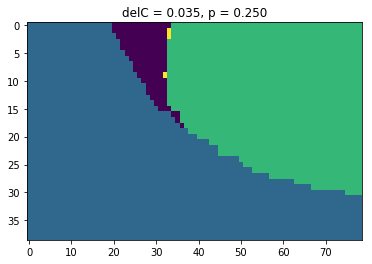

In [272]:
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
imshow(img, aspect='auto')
plt.title("delC = {:.3f}, p = {:.3f}".format(delC, p))
#plt.savefig("phase/sample3/phase_n_{}".format(n))

In [77]:
#plotting 
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
imshow(img, aspect='auto')
plt.title("delC = {:.3f}, p = {:.3f}".format(delC, p))

Text(0.5, 1.0, 'delC = 0.035, p = 0.167')

In [254]:
#Heterogeneous sigmoid 
N = 1000000 #50000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5.1 #1.
delVmin = delV/3 #delV/3
delC= 0.035 #0.025
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)
network.kill_neuron2(20)

avC,avV,C,V,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous", activation="sigmoid")

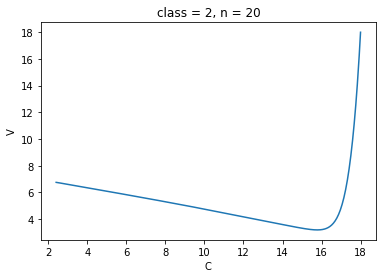

In [257]:
#print(classifier(avV, 1/dt, 0.1)) #0 is chaos, 1 is SO, 2 is FP, -1 is error
classification = classify(avV,params)
plot(avC[:],avV[:])
title("class = {}, n = {}".format(classification, network.n))
xlabel("C")
ylabel("V")
plt.savefig("phase/sample3/class_{}_n_{}".format(classification, network.n))

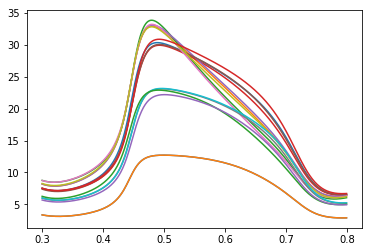

In [397]:
plot(T[300:800], V[300:800])


In [258]:
t = -1
G = nx.DiGraph()
for i in range(network.n): 
    if  V[t, i] > Vstar: # t = -1
        G.add_node(i, color='r', firing=True)
    else:
        G.add_node(i, color='y', firing=False)
        
for i in range(network.n): 
    for j in range(network.n): 
        if network.M[i,j] == 1: 
            G.add_edge(i,j)
            
            

In [259]:
clist = np.zeros(network.n, dtype=str)
for i in range(network.n):
    color = G.nodes.data()[i]['color']
    clist[i] = color


In [151]:
clist

array(['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y'], dtype='<U1')

In [345]:
G.degree

DiDegreeView({0: 4, 1: 7, 2: 9, 3: 5, 4: 5, 5: 7, 6: 6, 7: 6, 8: 8, 9: 4, 10: 9, 11: 1, 12: 3, 13: 7, 14: 7})

In [346]:
V[-1,:]


array([11.81546994, 12.55169464, 10.30996351, 10.79041983, 12.40434866,
       11.28898866, 11.79226038,  8.63432582, 12.33334569,  8.57865779,
        5.37362845,  5.37362845,  8.30311136, 11.14830639,  7.62180208])

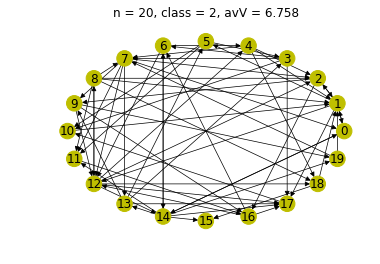

In [260]:
plt.title("n = {}, class = {}, avV = {:.3f}".format(network.n, classification, avV[t]))
nx.draw_circular(G, node_size=240, width=0.7, with_labels=True, node_color=clist)
#nx.draw_circular(G,node_size=20,width=0.5,edge_color='black',node_color='black',with_labels=True)
#nx.draw_circular(H,node_size=20,width=0.3,node_color='black', edge_color='black')
plt.savefig("phase/sample3/connectivity_class_{}_n_{}".format(classification, network.n), dpi=300)


### Heterogeneously connected, step function activation

# Investigation of network splitting 
1. Run simulation with random IC's 
2. Plot Initial and final states (network connectivity plot) 

### Homogeneous step

In [111]:
# Setup simulation parameters 
n = 20
p = 1
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [295]:
#mean field step function limit
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5. #1.
delVmin = delV/3 #delV/3
delC= 0.015 #0.01
r_1= 70#*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5#*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)


avC,avV,C,V,f = network.simdyn(network.M, network.l, network.params, connectivity="mean field", activation="step")

3


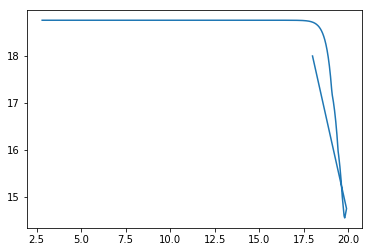

In [296]:
plot(avC,avV)
print(classify(avV,params))

In [300]:
G,H = nx.DiGraph(), nx.DiGraph()
# Add inital conditions to G
t = 0
for i in range(network.n): 
    if (V[t, i] > Vstar) and (C[t, i] < Cstar): #change condition
    #if  V[t, i] > Vstar:
        G.add_node(i, color='r', firing=True)
    else:
        G.add_node(i, color='y', firing=False)

'''for i in range(network.n): 
    for j in range(network.n): 
        if network.M[i,j] == 1: 
            G.add_edge(i,j)
'''            
#Add final state to H
t = -1
for i in range(network.n): 
    if  (V[t, i] > Vstar) and (C[t, i] < Cstar): 
    #if  V[t, i] > Vstar:
        H.add_node(i, color='r', firing=True)
    else:
        H.add_node(i, color='y', firing=False)
        
'''for i in range(network.n): 
    for j in range(network.n): 
        if network.M[i,j] == 1: 
            H.add_edge(i,j)'''
            
Gclist = np.zeros(network.n, dtype=str)
for i in range(network.n):
    color = G.nodes.data()[i]['color']
    Gclist[i] = color
    
Hclist = np.zeros(network.n, dtype=str)
for i in range(network.n):
    color = H.nodes.data()[i]['color']
    Hclist[i] = color
            

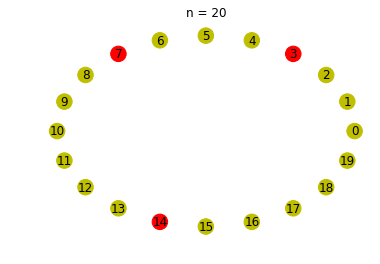

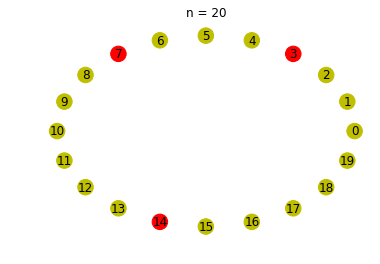

In [301]:
figure()
title("n = {}".format(network.n))
nx.draw_circular(G, node_size=240, width=0.7, with_labels=True, node_color=Gclist)
figure()
title("n = {}".format(network.n))
nx.draw_circular(H, node_size=240, width=0.7, with_labels=True, node_color=Hclist)

In [299]:
print("Vstar = ", Vstar)
print(V[0, :])
print(V[-1,:])

Vstar =  15
[15.90068712 15.71532719 14.31740965 15.77953982 14.7128016  14.88221332
 14.74695646 15.07713274 14.82576254 14.35006957 14.11367745 14.82704823
 14.99375633 14.14449571 15.67451329 15.23231138 14.09635345 15.03231418
 14.39127002 14.79201929]
[ 9.5   9.5   9.5  71.25  9.5   9.5   9.5  71.25  9.5   9.5   9.5   9.5
  9.5   9.5  71.25  9.5   9.5   9.5   9.5   9.5 ]


In [170]:
idx=15
print(V[0, idx])
print(V[-1,idx])

15.333742685983971
9.500000000000007


### Homogeneous Sigmoid

In [249]:
# Setup simulation parameters 
n = 20
p = 1
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [306]:
#mean field step function limit
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 7. #1.
delVmin = delV/3 #delV/3
delC= 0.01 #0.01
r_1= 100*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)

avC,avV,C,V = network.simdyn(network.M, network.l, network.params, connectivity="mean field", activation="sigmoid")

In [285]:
C

array([[20.92216948, 20.65755348, 20.76888575, ..., 19.0874205 ,
        20.16614199, 20.58228936],
       [20.9063703 , 20.64235652, 20.75333338, ..., 19.07534528,
        20.15178296, 20.56709804],
       [20.89140174, 20.62797553, 20.73861422, ..., 19.06404712,
        20.1382429 , 20.55272735],
       ...,
       [21.82224063, 21.82224063, 21.82224063, ..., 21.82224061,
        21.82224062, 21.82224062],
       [21.82224063, 21.82224063, 21.82224063, ..., 21.82224061,
        21.82224062, 21.82224062],
       [21.82224063, 21.82224063, 21.82224063, ..., 21.82224061,
        21.82224062, 21.82224062]])

1


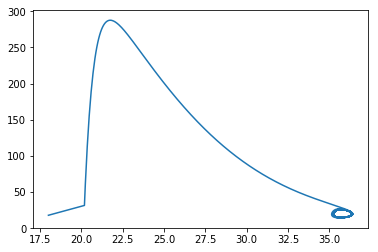

In [307]:
plot(avC,avV)
print(classify(avV,params))

In [304]:
G,H = nx.DiGraph(), nx.DiGraph()
# Add inital conditions to G
t = 0
for i in range(network.n): 
    #if (V[t, i] > Vstar) and (C[t, i] < Cstar): #change condition
    if  V[t, i] > Vstar:
        G.add_node(i, color='r', firing=True)
    else:
        G.add_node(i, color='y', firing=False)

'''for i in range(network.n): 
    for j in range(network.n): 
        if network.M[i,j] == 1: 
            G.add_edge(i,j)
'''            
#Add final state to H
t = -1
for i in range(network.n): 
    #if  (V[t, i] > Vstar) and (C[t, i] < Cstar): 
    if  V[t, i] > Vstar:
        H.add_node(i, color='r', firing=True)
    else:
        H.add_node(i, color='y', firing=False)
        
'''for i in range(network.n): 
    for j in range(network.n): 
        if network.M[i,j] == 1: 
            H.add_edge(i,j)'''
            
Gclist = np.zeros(network.n, dtype=str)
for i in range(network.n):
    color = G.nodes.data()[i]['color']
    Gclist[i] = color
    
Hclist = np.zeros(network.n, dtype=str)
for i in range(network.n):
    color = H.nodes.data()[i]['color']
    Hclist[i] = color

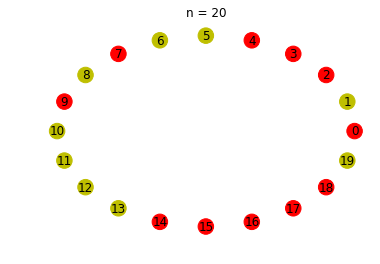

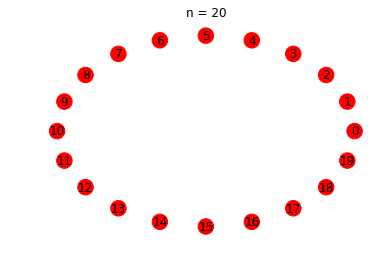

In [305]:
figure()
title("n = {}".format(network.n))
nx.draw_circular(G, node_size=240, width=0.7, with_labels=True, node_color=Gclist)
figure()
title("n = {}".format(network.n))
nx.draw_circular(H, node_size=240, width=0.7, with_labels=True, node_color=Hclist)

# How many fixed points exist for a heterogeneous network

### Heterogeneous Step

In [897]:
# Setup simulation parameters 
n = 100
p = 1.
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [960]:
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 4.83 #15.
delVmin = delV/3 #delV/3
delC= 0.0092 #0.03
r_1= 70#*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5#*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)
network.kill_neuron2(40) #80

#variables for final state mapping 
#state_map = {final_state:list(init_states)}
state_map = {}
n_iters = 10000 #2000

def binarize(arr, thresh):
    '''
        binarizes an array arr according to threshold thresh into 1's and 0's. Returns as tupled type to 
        be able to hash by data later. 
    '''
    arr_len = len(arr)
    return tuple([1 if (arr[i] > thresh) else 0 for i in range(arr_len)])

for i in range(n_iters):
    avC,avV,C,V = network.simdyn(network.M, network.l, 
                                      network.params, connectivity="heterogeneous", activation="step")
    
    if classify(avV, params) == 3 or classify(avV, params) == 2:
        V_bin = [binarize(V[0], Vstar), binarize(V[-1], Vstar)]

        if V_bin[-1] not in state_map: 
            state_map[V_bin[-1]] = [V_bin[0]]

        elif V_bin[0] not in state_map[V_bin[-1]]:
            state_map[V_bin[-1]].append(V_bin[0])
    




In [961]:
len(state_map)

1759

In [500]:
len(sorted(state_map[V_bin[-1]]))

10

2


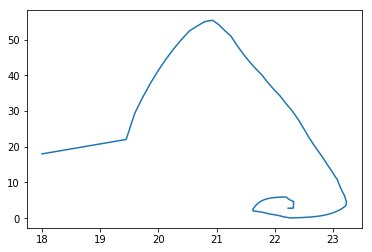

In [852]:
print(classify(avV,params))
plot(avC,avV)

In [956]:
firing_counts_dict = {}
for key, value in state_map.items() :
    firing_count = sum(key)
    if firing_count not in firing_counts_dict:
        firing_counts_dict[firing_count] = 1
    else:
        firing_counts_dict[firing_count] += 1
print(key)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)


In [957]:
firing_counts_dict

{58: 1}

In [553]:
a = (1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1)
state_map[a]
print("Firing at end = ", sum(a))


Firing at end =  13


In [554]:
state_map[a]

[(0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0)]

In [600]:
V.shape

(100000, 20)

In [602]:
V[:5,:]

array([[13.81643176, 12.97499736, 12.02367571, 14.50721528, 13.60308306,
        14.3649963 , 14.83580488, 12.109899  , 14.41406253, 13.23259994,
        13.55058283, 12.90923224, 13.22807418, 13.17222068, 12.93793798,
        12.64944467, 12.35979946, 12.6992626 , 13.85310715, 14.15755631],
       [13.96326744, 13.13024739, 12.18843896, 14.64714312, 13.75205223,
        14.50634633, 14.97244683, 12.27380001, 14.55492191, 13.38527394,
        13.700077  , 13.06513992, 13.38079344, 13.32549847, 13.0935586 ,
        12.80795023, 12.52120147, 12.85726997, 13.99957608, 14.30098075],
       [14.10863477, 13.28394491, 12.35155457, 14.78567169, 13.89953171,
        14.64628287, 15.10772236, 12.43606201, 14.69437269, 13.5364212 ,
        13.84807623, 13.21948852, 13.5319855 , 13.47724349, 13.24762301,
        12.96487073, 12.68098945, 13.01369727, 14.14458032, 14.44297094],
       [14.25254842, 13.43610546, 12.51303902, 14.92281497, 14.04553639,
        14.78482004, 17.09414513, 12.59670139, 1

In [601]:
C[0,:]

array([17.27600321, 18.3069978 , 18.91382783, 19.86571154, 17.21833547,
       18.6312376 , 19.30960371, 19.56008556, 17.43571932, 17.43085774,
       18.59804315, 19.19952661, 19.78561809, 19.11117062, 19.40387123,
       19.9024337 , 18.67870765, 17.78427658, 18.39524112, 18.64480439])

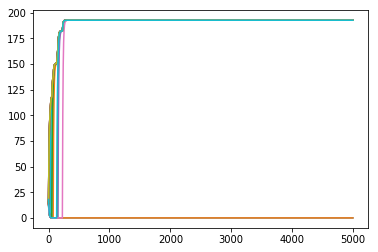

In [665]:
for i in range(len(V[0])): 
    plot(V[:5000,i])

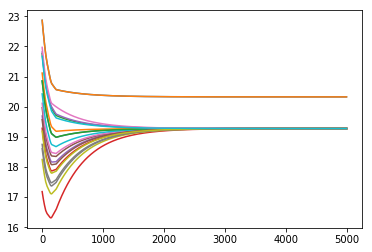

In [666]:
for i in range(len(C[0])): 
    plot(C[:5000,i])

In [570]:
len(V[0])

20

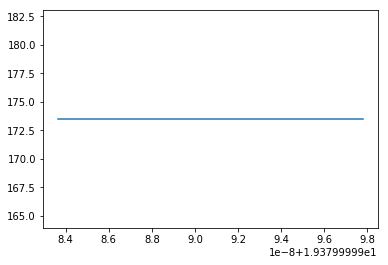

In [664]:
plot(avC[9000:],avV[9000:])

### mega loop checking number of fixed points for different p values

In [888]:
n = 100
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 7.3 #15.
delVmin = delV/3 #delV/3
delC= 0.015 #0.03
r_1= 70#*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5#*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

In [889]:
#generate region of interest only
a = np.arange(0.5,0.8,0.1)
b = np.arange(0.8,1.01,0.01)
p_vals = np.concatenate((a,b))
n_iters = 2000
results = []

def binarize(arr, thresh):
    arr_len = len(arr)
    return tuple([1 if (arr[i] > thresh) else 0 for i in range(arr_len)])

for p in p_vals:
    print("p visited: ", p)
    #import pdb; pdb.set_trace()
    M = getRandomConnectivity(n, p)
    l = matrixOfEdges(M, n)
    
    params[1] = n
    network = Network(M, l, params)
    network.kill_neuron2(60)
    
    state_map = {}
    
    for i in range(n_iters):
        avC,avV,C,V = network.simdyn(network.M, network.l, 
                                      network.params, connectivity="heterogeneous", activation="step")
    
        if classify(avV, params) == 3 or classify(avV, params) == 2:
            V_bin = [binarize(V[0], Vstar), binarize(V[-1], Vstar)]

            if V_bin[-1] not in state_map: 
                state_map[V_bin[-1]] = [V_bin[0]]

            elif V_bin[0] not in state_map[V_bin[-1]]:
                state_map[V_bin[-1]].append(V_bin[0])
    
    del network
                
    results.append(len(state_map))

p visited:  0.5
p visited:  0.6
p visited:  0.7
p visited:  0.7999999999999999
p visited:  0.8
p visited:  0.81
p visited:  0.8200000000000001
p visited:  0.8300000000000001
p visited:  0.8400000000000001
p visited:  0.8500000000000001
p visited:  0.8600000000000001
p visited:  0.8700000000000001
p visited:  0.8800000000000001
p visited:  0.8900000000000001
p visited:  0.9000000000000001
p visited:  0.9100000000000001
p visited:  0.9200000000000002
p visited:  0.9300000000000002
p visited:  0.9400000000000002
p visited:  0.9500000000000002
p visited:  0.9600000000000002
p visited:  0.9700000000000002
p visited:  0.9800000000000002
p visited:  0.9900000000000002
p visited:  1.0000000000000002


In [848]:
results

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

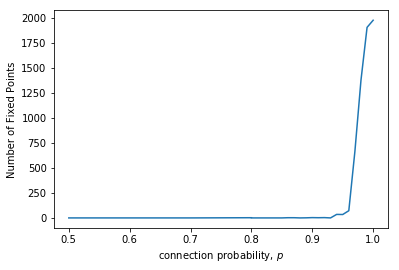

In [891]:
plot(p_vals, results)
xlabel(r"connection probability, $p$")
ylabel("Number of Fixed Points")
#plt.savefig("paper_figures/fp_enumeration_n_60.png")

In [683]:
a = [1,2]
b = [3,4]
c = a+b
c

[1, 2, 3, 4]

In [693]:
c

array([0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
       0.97, 0.98, 0.99, 1.  ])

# Vary $g_V$ and $g_C$ individually

### Vary $g_V$ only

In [969]:
n = 150
p = 3/4
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [970]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5. #1.
delVmin = delV/3 #delV/3
delC= 0.03 #0.03
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 0.1
g_c = 3

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dg = 0.1
g_max = 7.

g_space = np.arange(g_v, g_max, dg)
n_space = np.arange(2,n+1)

phase = np.zeros((len(n_space), len(g_space)))

network = Network(M, l, params)

for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(g_space)):
        #import pdb; pdb.set_trace()
        network.params[12] = g_space[j]
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous",
                                             activation="sigmoid")
        check = classify2(V,params)
        phase[i,j] = check
    print("Visited n = {}".format(i))

print('loop complete')


Visited n = 148
Visited n = 147
Visited n = 146
Visited n = 145
Visited n = 144
Visited n = 143
Visited n = 142
Visited n = 141
Visited n = 140
Visited n = 139
Visited n = 138
Visited n = 137
Visited n = 136
Visited n = 135
Visited n = 134
Visited n = 133
Visited n = 132
Visited n = 131
Visited n = 130
Visited n = 129
Visited n = 128
Visited n = 127
Visited n = 126
Visited n = 125
Visited n = 124
Visited n = 123
Visited n = 122
Visited n = 121
Visited n = 120
Visited n = 119
Visited n = 118
Visited n = 117
Visited n = 116
Visited n = 115
Visited n = 114
Visited n = 113
Visited n = 112
Visited n = 111
Visited n = 110
Visited n = 109
Visited n = 108
Visited n = 107
Visited n = 106
Visited n = 105
Visited n = 104
Visited n = 103
Visited n = 102
Visited n = 101
Visited n = 100
Visited n = 99
Visited n = 98
Visited n = 97
Visited n = 96
Visited n = 95
Visited n = 94
Visited n = 93
Visited n = 92
Visited n = 91
Visited n = 90
Visited n = 89
Visited n = 88
Visited n = 87
Visited n = 86
Visite

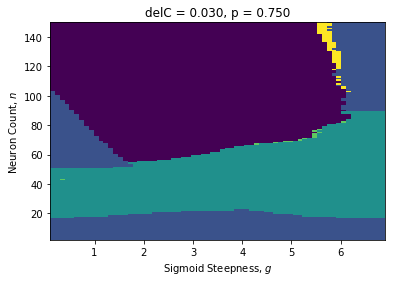

In [972]:
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
imshow(img, aspect='auto', extent=[g_space[0],g_space[-1],n_space[0],n_space[-1]])
plt.title("delC = {:.3f}, p = {:.3f}".format(delC, p))
xlabel(r"Sigmoid Steepness, $g$")
ylabel(r"Neuron Count, $n$")
savefig("paper_figures/gv_variation")

In [975]:
data

array([[1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [974]:
data.shape

(149, 69)

### Vary $g_C$ only

In [ ]:
n = 150
p = 3/4
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [976]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5. #1.
delVmin = delV/3 #delV/3
delC= 0.03 #0.03
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 3.
g_c = 0.1

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dg = 0.1
g_max = 7.

g_space = np.arange(g_v, g_max, dg)
n_space = np.arange(2,n+1)

phase = np.zeros((len(n_space), len(g_space)))

network = Network(M, l, params)

for i in reversed(range(len(n_space))):
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(g_space)):
        #import pdb; pdb.set_trace()
        network.params[13] = g_space[j]
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous",
                                             activation="sigmoid")
        check = classify2(V,params)
        phase[i,j] = check
    print("Visited n = {}".format(i))

print('loop complete')


Visited n = 148
Visited n = 147
Visited n = 146
Visited n = 145
Visited n = 144
Visited n = 143
Visited n = 142
Visited n = 141
Visited n = 140
Visited n = 139
Visited n = 138
Visited n = 137
Visited n = 136
Visited n = 135
Visited n = 134
Visited n = 133
Visited n = 132
Visited n = 131
Visited n = 130
Visited n = 129
Visited n = 128
Visited n = 127
Visited n = 126
Visited n = 125
Visited n = 124
Visited n = 123
Visited n = 122
Visited n = 121
Visited n = 120
Visited n = 119
Visited n = 118
Visited n = 117
Visited n = 116
Visited n = 115
Visited n = 114
Visited n = 113
Visited n = 112
Visited n = 111
Visited n = 110
Visited n = 109
Visited n = 108
Visited n = 107
Visited n = 106
Visited n = 105
Visited n = 104
Visited n = 103
Visited n = 102
Visited n = 101
Visited n = 100
Visited n = 99
Visited n = 98
Visited n = 97
Visited n = 96
Visited n = 95
Visited n = 94
Visited n = 93
Visited n = 92
Visited n = 91
Visited n = 90
Visited n = 89
Visited n = 88
Visited n = 87
Visited n = 86
Visite

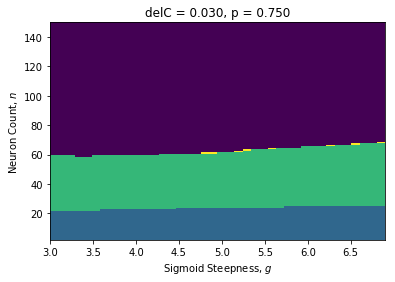

In [978]:
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
imshow(img, aspect='auto', extent=[g_space[0],g_space[-1],n_space[0],n_space[-1]])
plt.title("delC = {:.3f}, p = {:.3f}".format(delC, p))
xlabel(r"Sigmoid Steepness, $g$")
ylabel(r"Neuron Count, $n$")
savefig("paper_figures/gc_variation")

# Phase Diagram with k-core plotted simultaneously 

In [990]:
n = 150
p = 1/6
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5. #1.
delVmin = delV/3 #delV/3
delC= 0.03 #0.03
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 3.
g_c = 0.1

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M,l,params)
network.kill_neuron2(120)

In [991]:
largestkcore(network.M)

4.0